In [82]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_curve,auc,classification_report

In [3]:
cancer_data = pd.read_csv('data.csv')

In [4]:
df = cancer_data.copy()

In [5]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### Composition of classification column

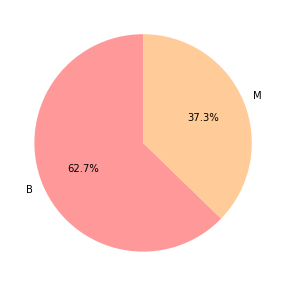

In [6]:
plt.figure(figsize=(5,5))
plt.pie(df['diagnosis'].value_counts().values,labels=df['diagnosis'].value_counts().index,autopct="%1.1f%%",colors=['#ff9999','#ffcc99'], startangle=90)
plt.show()

Benign cases are more.

__% null values__

In [7]:
df.isnull().sum()*100/len(df)

id                           0.0
diagnosis                    0.0
radius_mean                  0.0
texture_mean                 0.0
perimeter_mean               0.0
area_mean                    0.0
smoothness_mean              0.0
compactness_mean             0.0
concavity_mean               0.0
concave points_mean          0.0
symmetry_mean                0.0
fractal_dimension_mean       0.0
radius_se                    0.0
texture_se                   0.0
perimeter_se                 0.0
area_se                      0.0
smoothness_se                0.0
compactness_se               0.0
concavity_se                 0.0
concave points_se            0.0
symmetry_se                  0.0
fractal_dimension_se         0.0
radius_worst                 0.0
texture_worst                0.0
perimeter_worst              0.0
area_worst                   0.0
smoothness_worst             0.0
compactness_worst            0.0
concavity_worst              0.0
concave points_worst         0.0
symmetry_w

Can drop unnamed column. 'ID" column can be made index.

In [8]:
df.drop(columns=['Unnamed: 32'],inplace = True)

In [9]:
df.set_index(['id'],inplace=True)

__Check duplicate rows__

In [10]:
df.duplicated().sum()

0

No duplicate rows!

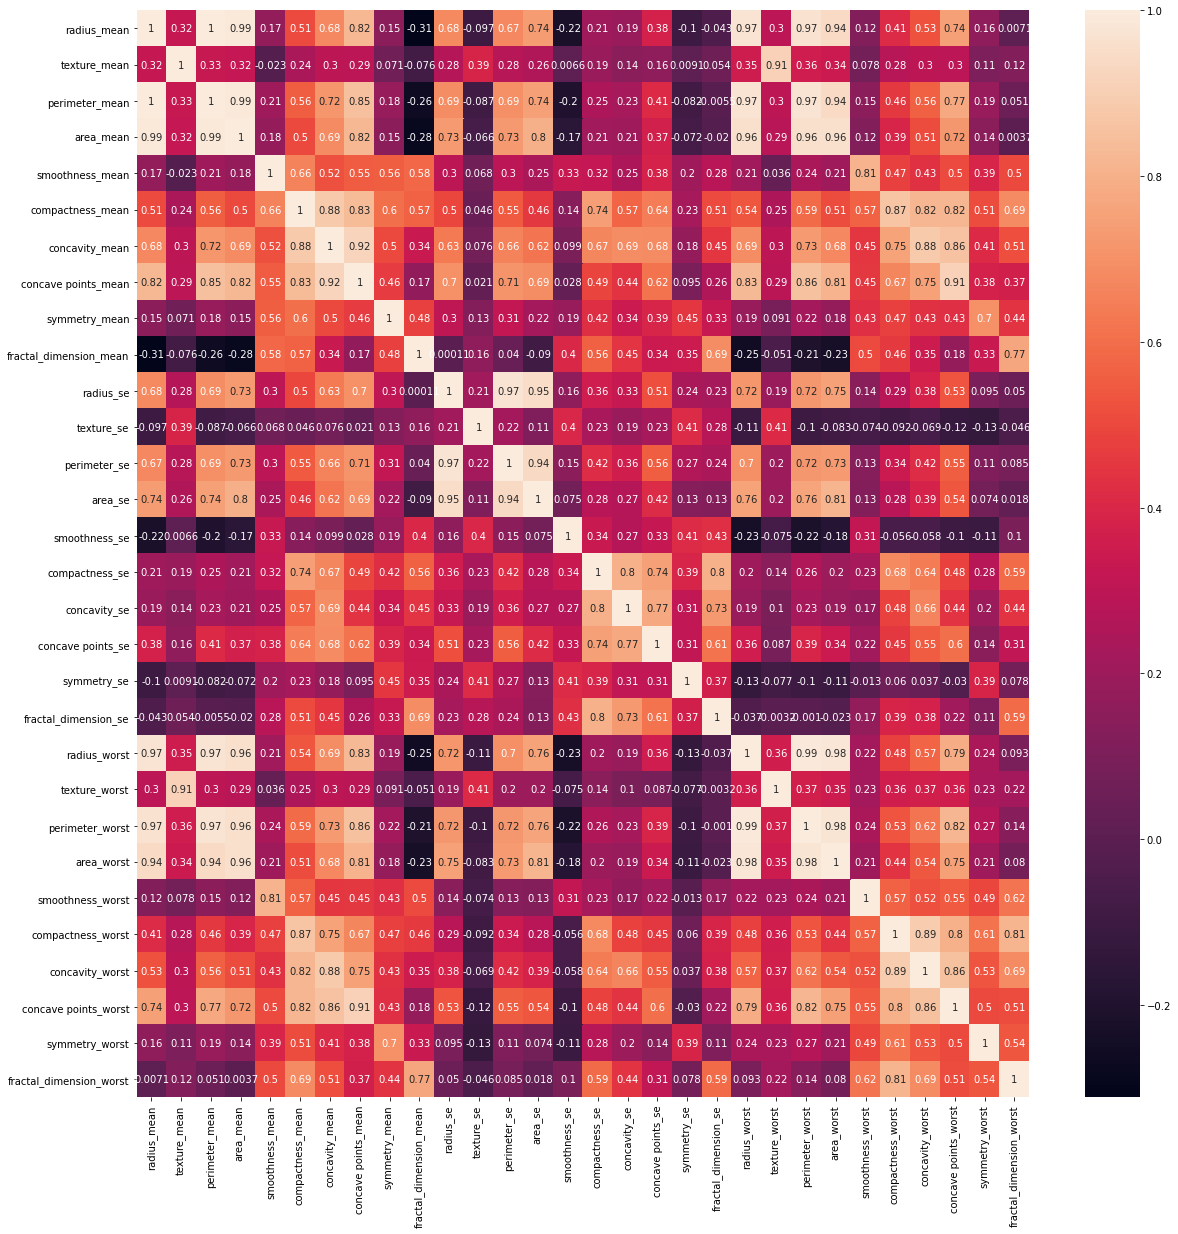

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(data=df.corr(),annot=True)
plt.show()

# Drop highly correlated columns where corr>75% 

In [12]:
def drop_highly_corr_columns(df_corr,df,corr_cutoff = 0.75):
    #Logic to drop columns with >75% corr with another column
    dropped_list=[] # create a list of dropped column so that they aren't covered as index when looping
    for i,index in enumerate(df_corr.index.values):
        if index not in dropped_list:
            for col in df_corr.index:
                if col in df.columns.values:
                    if (df_corr[col].iloc[i] > corr_cutoff ) & (df_corr[col].iloc[i] != 1.0 ) :
                        dropped_list.append(col)
                        df.drop(columns=[col],inplace=True)
    return df


In [13]:
df_corr = df.corr()
df = drop_highly_corr_columns(df_corr,df,corr_cutoff = 0.75)

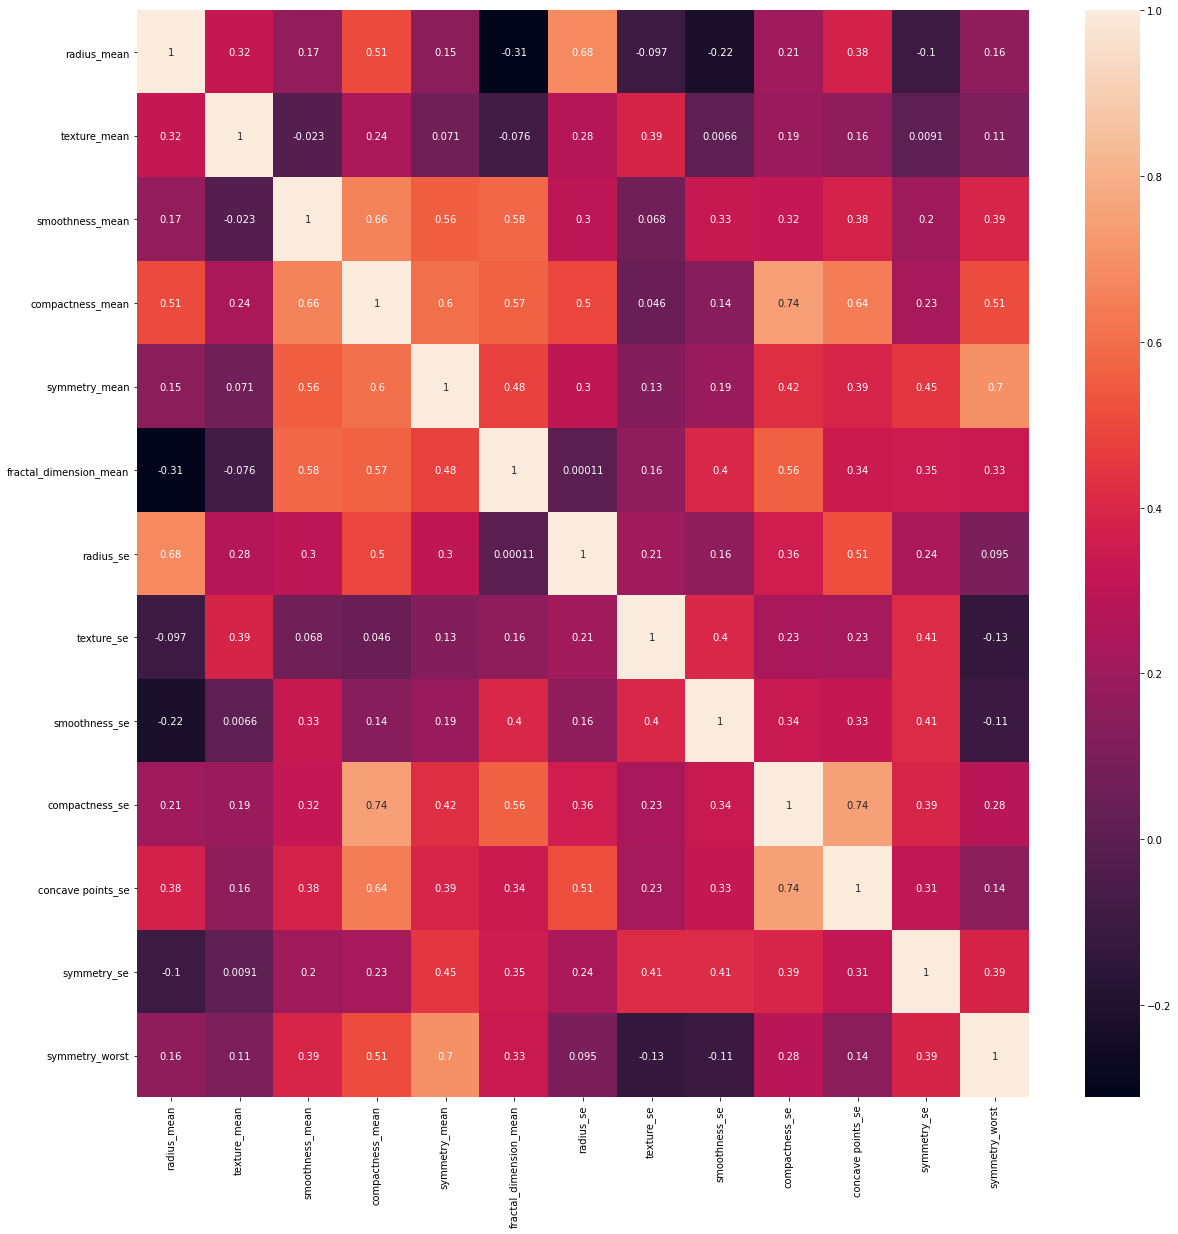

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(data=df.corr(),annot=True)
plt.show()

# Analyse columns

### OUTLIERS - TODO

In [15]:
df

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concave points_se,symmetry_se,symmetry_worst
id,,,,,,,,,,,,,,
842302,M,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.01587,0.03003,0.4601
842517,M,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01340,0.01389,0.2750
84300903,M,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.02058,0.02250,0.3613
84348301,M,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.01867,0.05963,0.6638
84358402,M,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01885,0.01756,0.2364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,0.11100,0.11590,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.02454,0.01114,0.2060
926682,M,20.13,28.25,0.09780,0.10340,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.01678,0.01898,0.2572
926954,M,16.60,28.08,0.08455,0.10230,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.01557,0.01318,0.2218


In [16]:
num_columns = df.columns.values[1:]

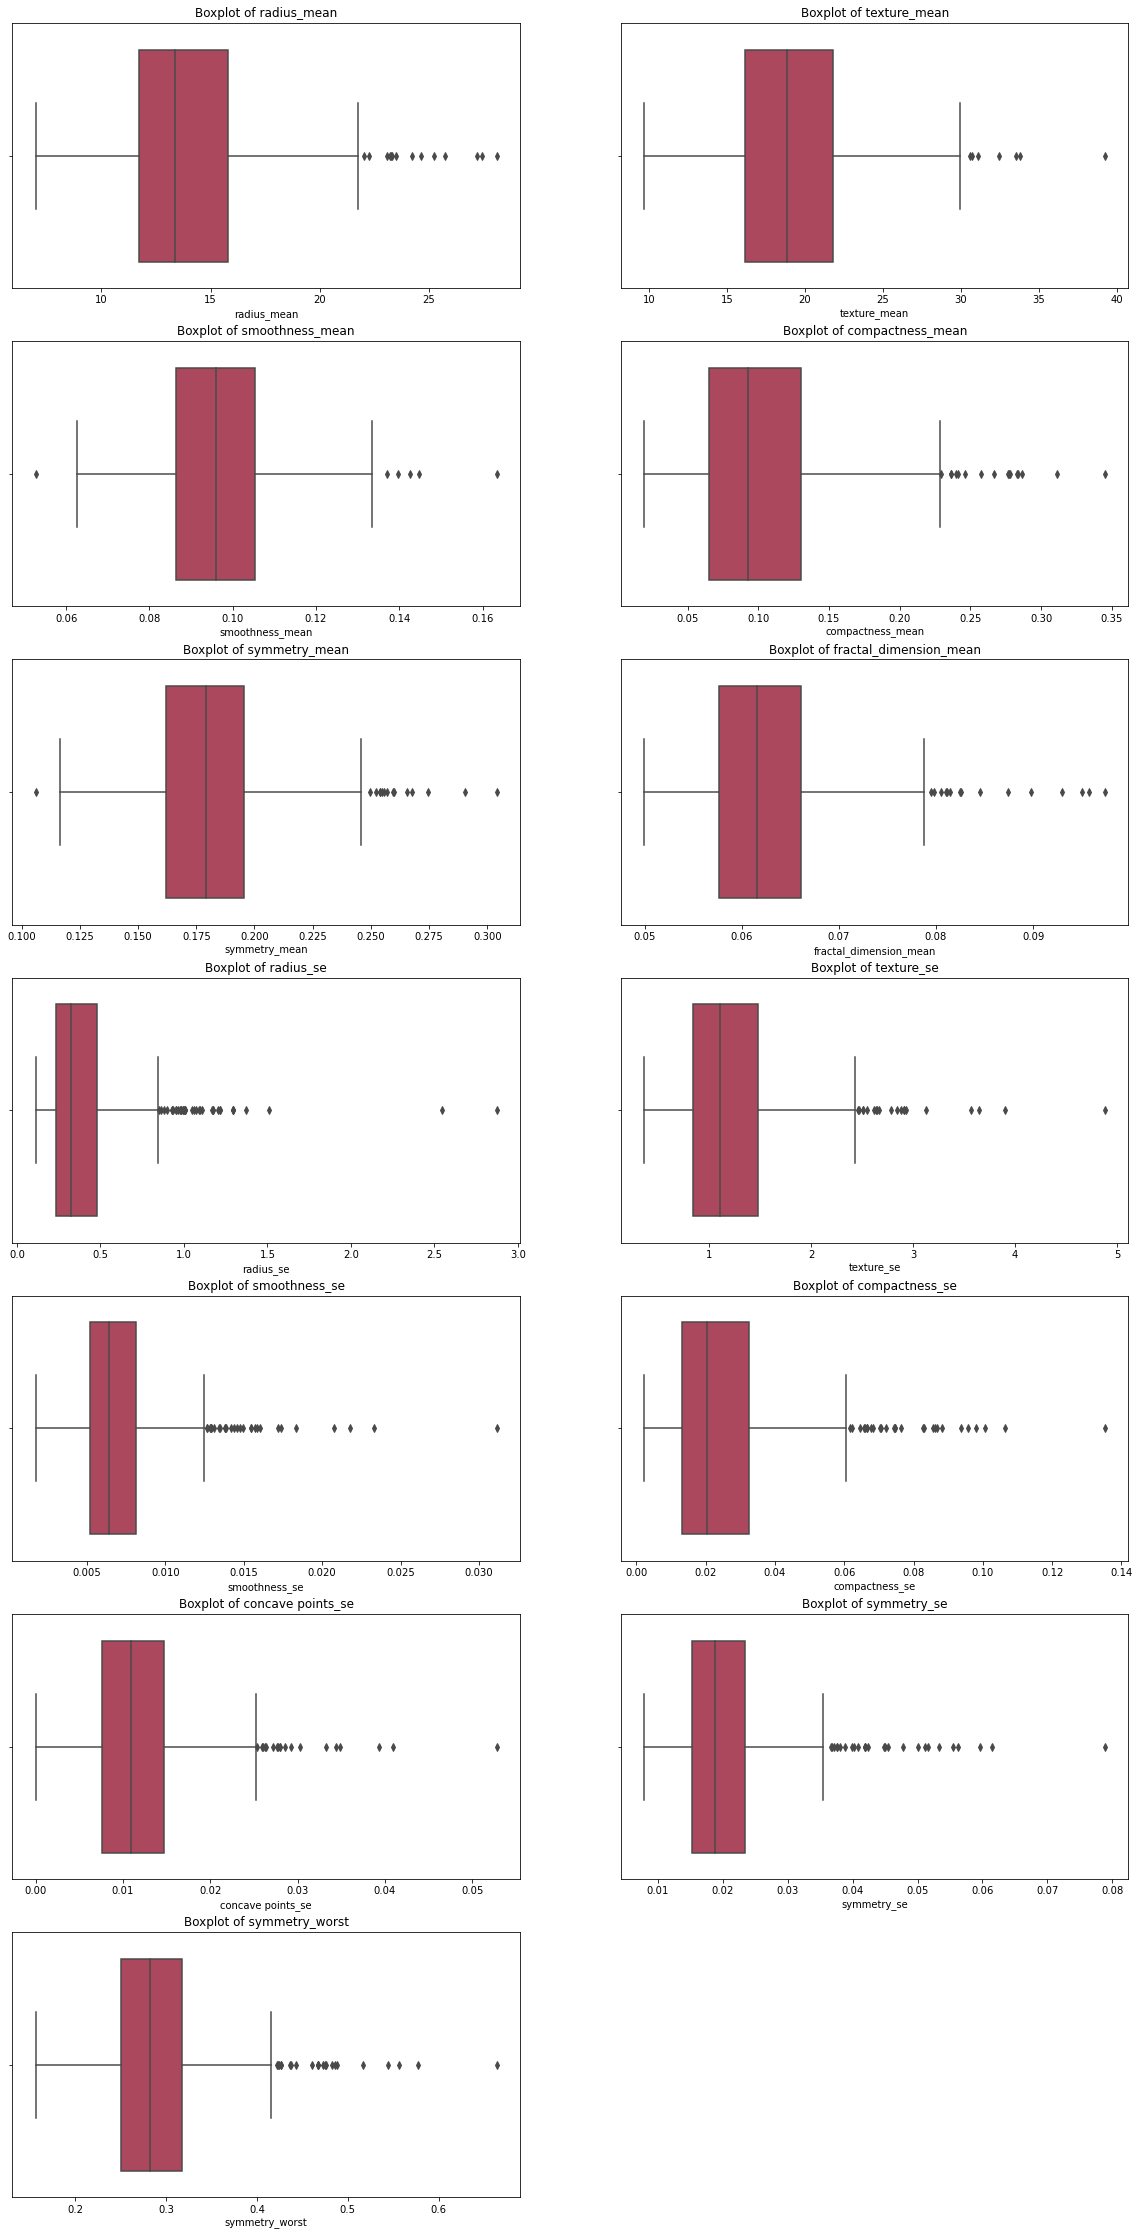

In [17]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns):
    plt.subplot(7,2,i+1)
    sns.boxplot(x=col,data=df,palette='inferno')
    plt.title("Boxplot of {}".format(col))
    
plt.show()

### SCATTER PLOTS

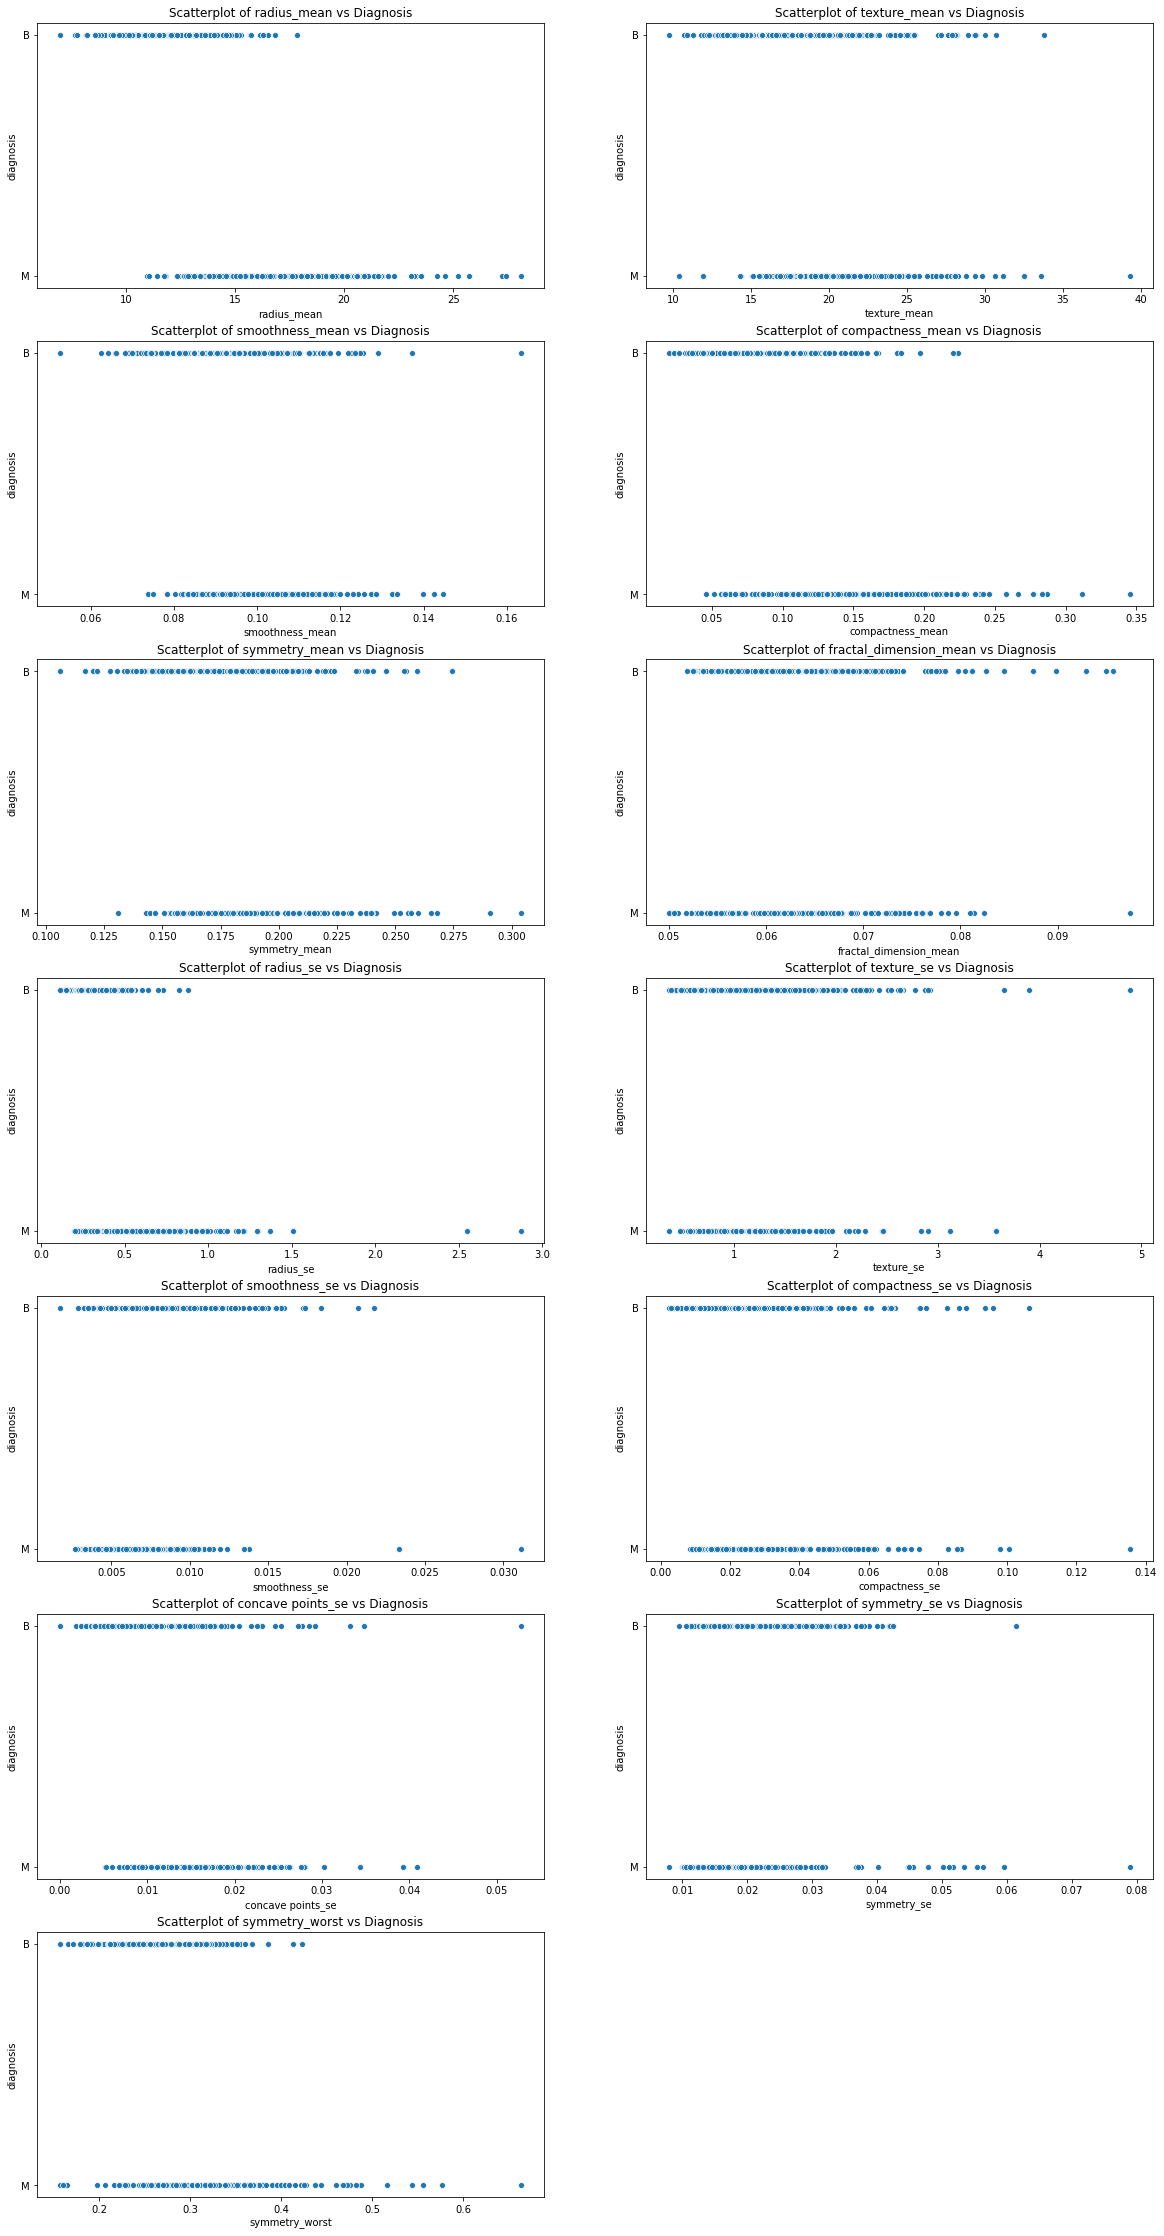

In [18]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns):
    plt.subplot(7,2,i+1)
    sns.scatterplot(x=col,y='diagnosis',data=df)
    plt.title("Scatterplot of {} vs Diagnosis".format(col))
    
plt.show()

For observations with __higher values__ of the following column indicate presence of __Malignant cells__ 

__radius_mean__

__compactness_mean__

__symmetry_se__

__symmetry_worst__

For observations with __higher values__ of the following column indicate__no__ presence of __Malignant cells__ 

__fractal_dimension_mean__

### Pair Plots

<Figure size 1440x1440 with 0 Axes>

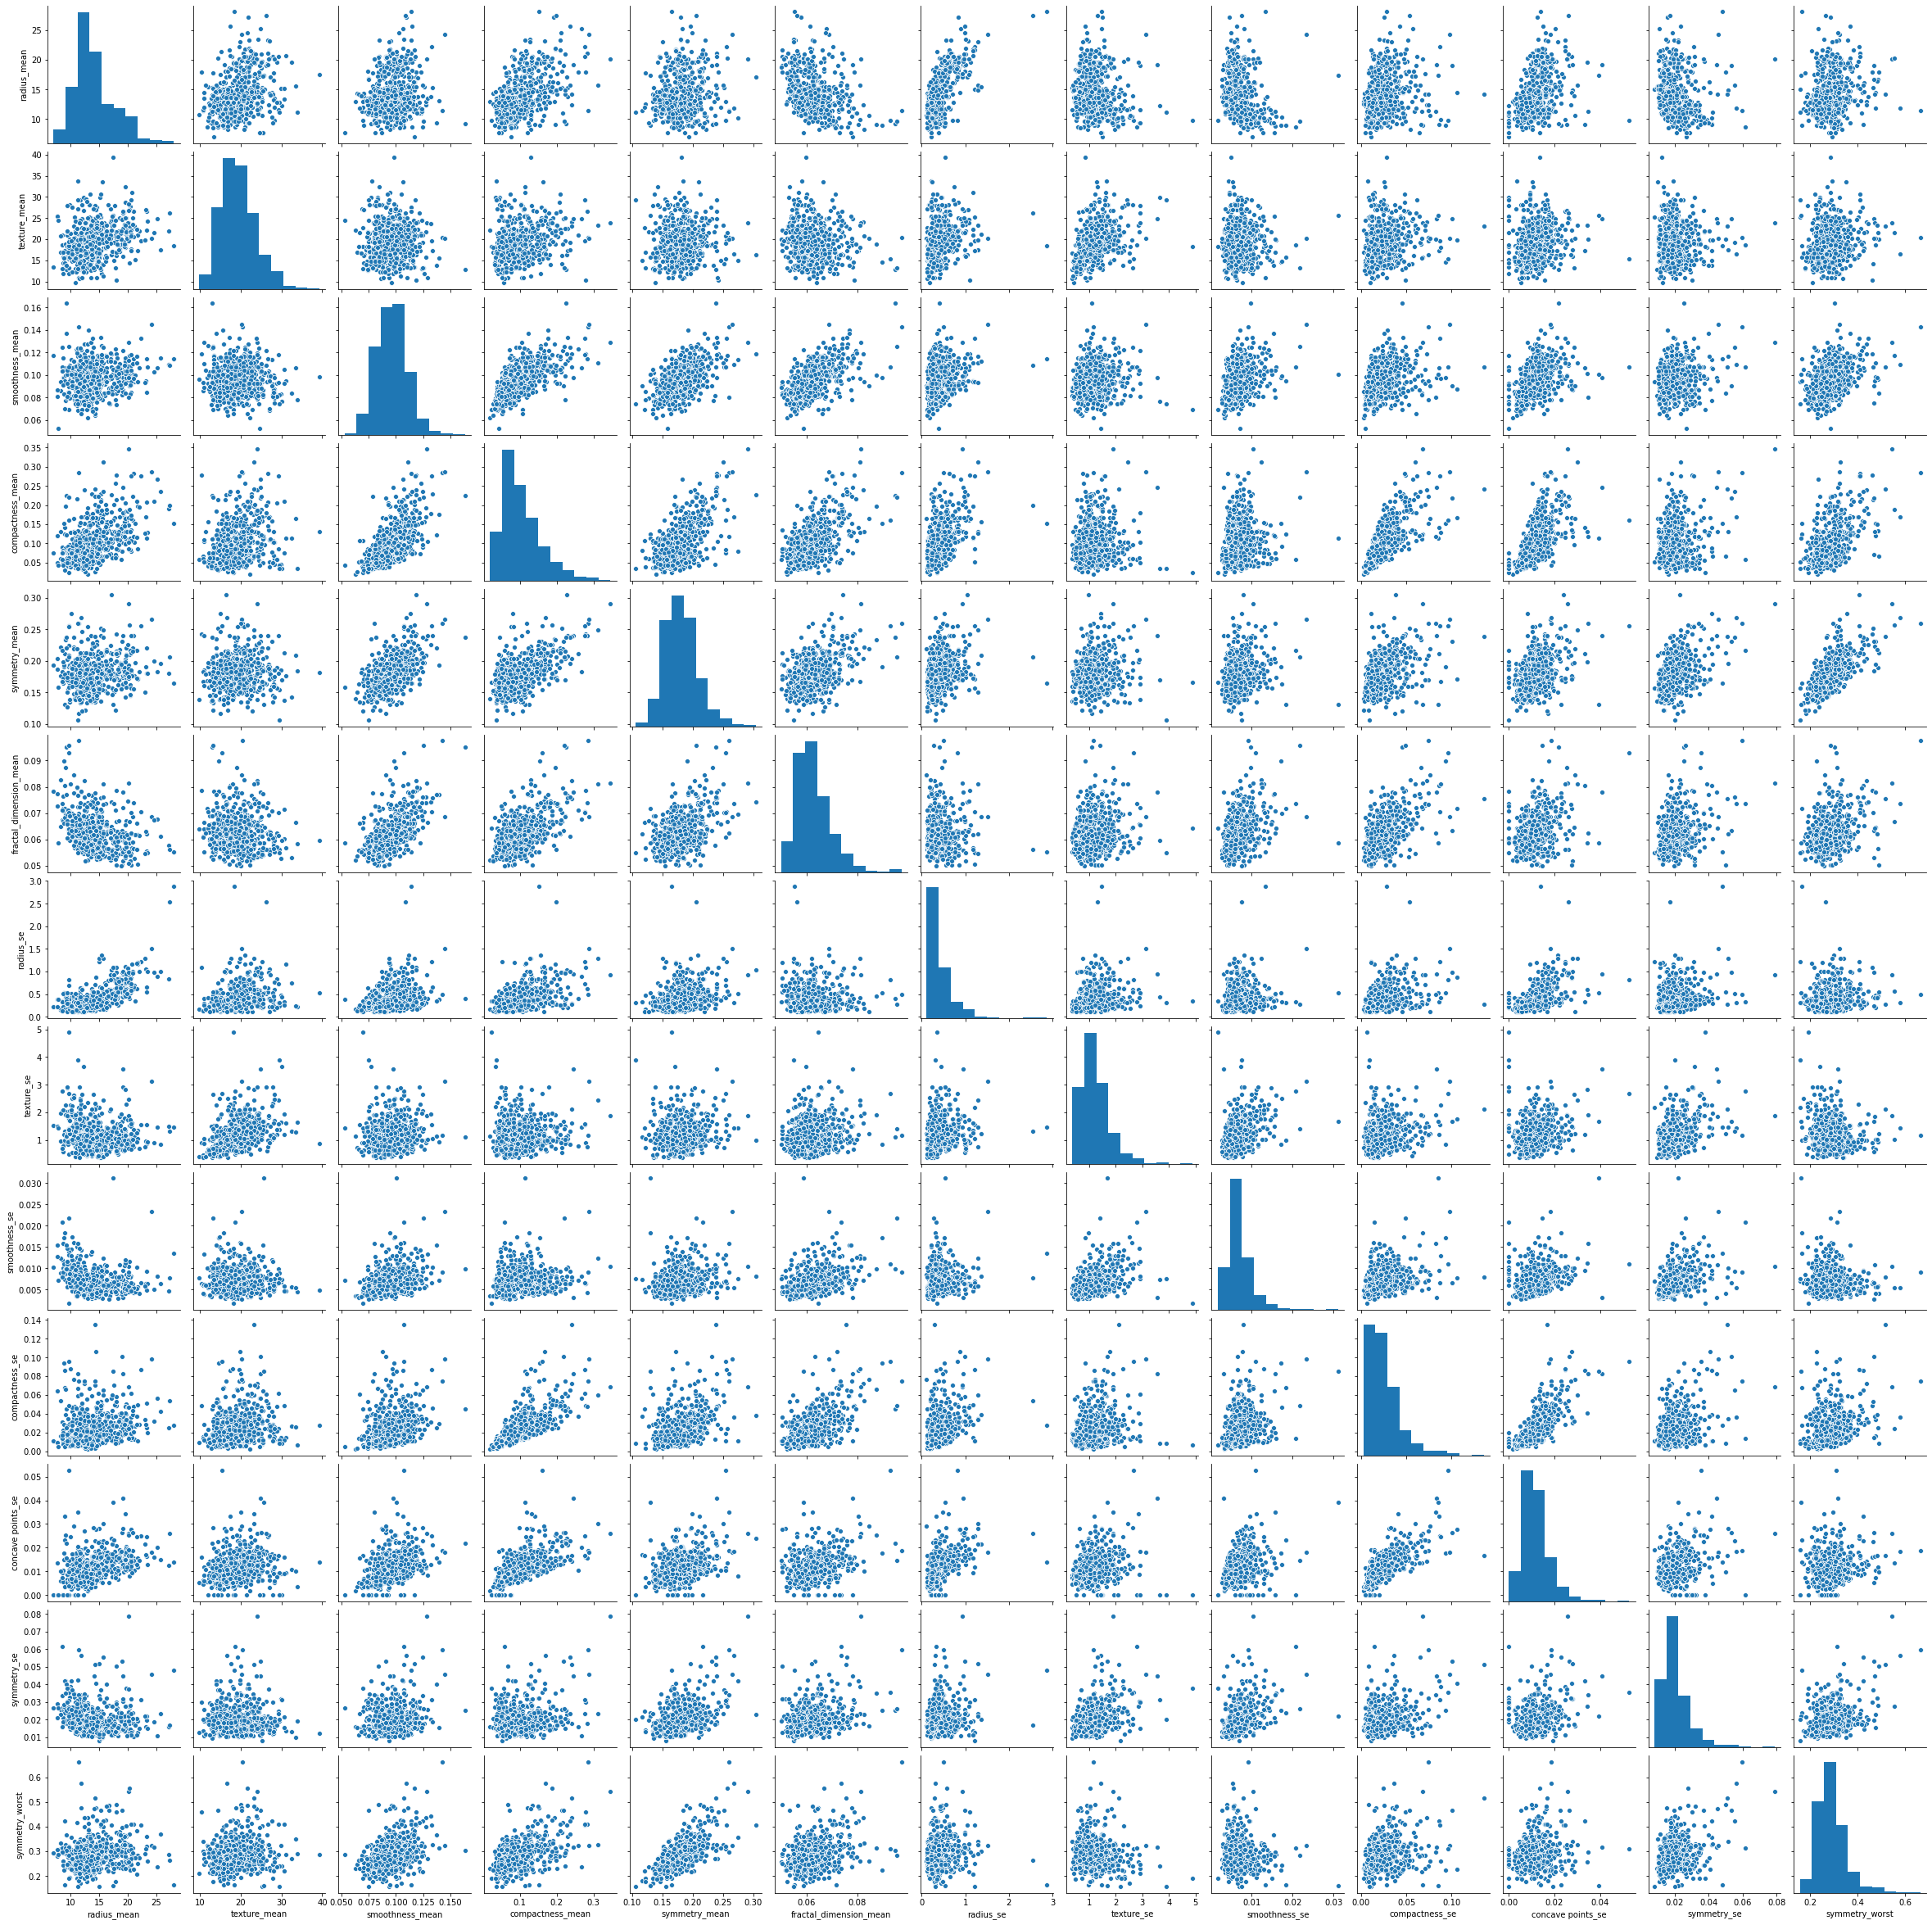

In [19]:
plt.figure(figsize=(20,20))
sns.pairplot(data=df,palette='inferno')
plt.show()

In [20]:
#Convert class colinto numerical column
df['diagnosis']= df['diagnosis'].map({"B":0,"M":1})# It is importnat that all malignant be identified. hence, we care more about predicting 1s as 1s.

### Split Dataset for Testing and Training

In [21]:
x = df.iloc[:,df.columns != 'diagnosis'] #features
Y = df.iloc[:,df.columns == 'diagnosis']#classification

x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=0.20,random_state=42)

In [22]:
x

,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concave points_se,symmetry_se,symmetry_worst
id,,,,,,,,,,,,,
842302,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.01587,0.03003,0.4601
842517,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01340,0.01389,0.2750
84300903,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.02058,0.02250,0.3613
84348301,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.01867,0.05963,0.6638
84358402,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01885,0.01756,0.2364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,21.56,22.39,0.11100,0.11590,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.02454,0.01114,0.2060
926682,20.13,28.25,0.09780,0.10340,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.01678,0.01898,0.2572
926954,16.60,28.08,0.08455,0.10230,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.01557,0.01318,0.2218


Flatten data into arrays

In [23]:
Y_train = Y_train.values.ravel() # can also use flatten()

In [24]:
Y_test = Y_test.values.ravel() 


# Random Forest Model

In [25]:
fit_rf =  RandomForestClassifier(random_state=42)

# Optimum values of Hyper-Parameters using GridSearchCV

In [26]:
param_dict = {'max_depth' : [2,4,8,16] ,#layers in the trees 
              'bootstrap':[True,False], # feautures are used with replacement for different trees
              'max_features':['auto','sqrt','log2','None'],# auto -  the features which make sense in every tree.
              'criterion':['gini','entropy']
    
}
grid_cv_rf = GridSearchCV(fit_rf,cv=10, param_grid=param_dict,n_jobs=3)#cv is cross validation
grid_cv_rf.fit(x_train,Y_train)
print('Best Parameters using grid search : \n',grid_cv_rf.best_params_)

Best Parameters using grid search : 
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}


__Now set params as provided by Grid Search CV__

In [29]:
fit_rf.set_params(bootstrap= True, criterion = 'entropy', max_depth = 8, max_features= 'auto')#oob only works for bootstrap=true

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=15,
                       oob_score=True, random_state=42, warm_start=True)

# OOB Rate - Find optimal number of trees in forest

In [30]:
fit_rf.set_params(warm_start=True,oob_score=True) #warm start -> If it is set to True, it permits the use of the existing fitted model attributes to initialize a new model in a subsequent call to fit. 

min_estimators=15
max_estimators =1000

error_rate = {}

for i in range(min_estimators,max_estimators):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(x_train,Y_train)
    
    oob_error=1-fit_rf.oob_score_
    error_rate[i] = oob_error

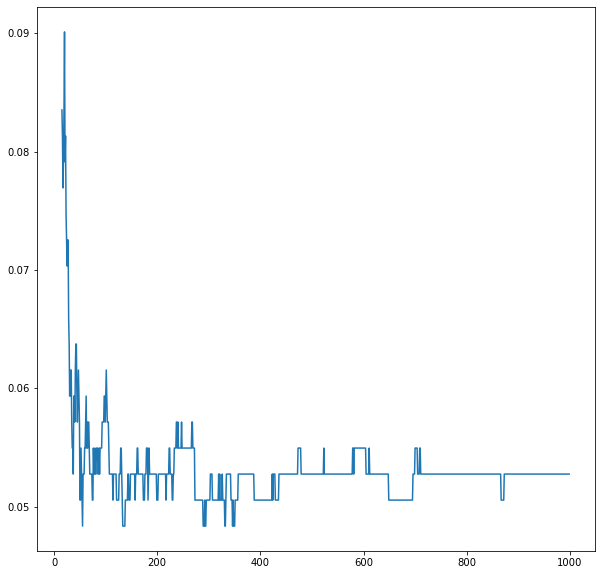

In [43]:
plt.figure(figsize=(10,10))
plt.plot(pd.Series(error_rate))

Looking at above plot number of estimators around __650-700__ would make sense as oob error rate is lesser and stable in the range

# Train the model

In [45]:
fit_rf.fit(x_train,Y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=999,
                       oob_score=True, random_state=42, warm_start=True)

### Predictions

In [46]:
Y_predictions = fit_rf.predict(x_test)

### Confusion Matrix

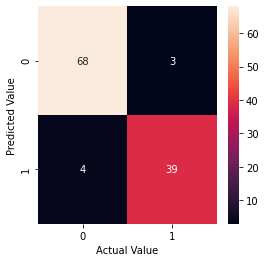

In [50]:
plt.figure(figsize=(4,4))
s=sns.heatmap(data=confusion_matrix(Y_test,Y_predictions),annot=True)
s.set(xlabel='Actual Value', ylabel='Predicted Value')
plt.show()
plt.show()

### Accuracy score

In [58]:
accuracy = fit_rf.score(x_test,Y_test)
print("Our model accuracy is : {0:.2f}%".format(accuracy*100)) # can also use accuracy_score function

Our model accuracy is : 93.86%


### Error Rate

In [61]:
test_error_rate = 1 - accuracy
print("Our model test error rate is : {0:.2f}%".format(test_error_rate*100))

Our model test error rate is : 6.14%


### AUC

In [70]:
pred_prob=fit_rf.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf,_ = roc_curve(Y_test,pred_prob)
auc_rf = auc(fpr_rf,tpr_rf)

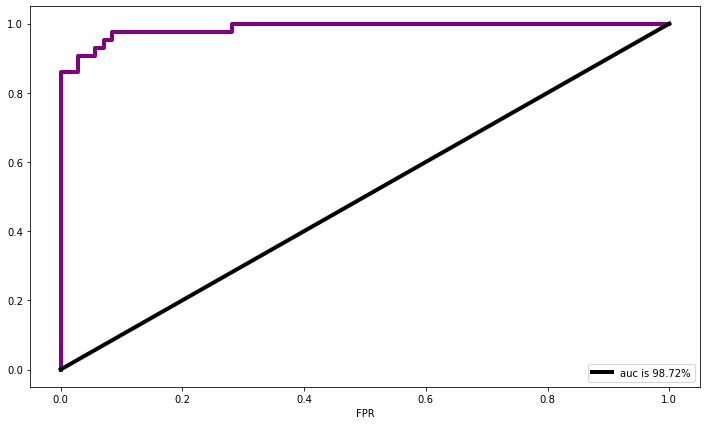

In [79]:
plt.figure(figsize=(12,7))
plt.plot(fpr_rf,tpr_rf,lw=4,color='purple')
plt.xlabel("TPR")
plt.xlabel("FPR")
plt.plot([0,1],[0,1],lw=4,color='black',label="auc is {0:.2f}%".format(auc_rf*100))
plt.legend(loc='lower right')
plt.show()


### Classification Report

In [86]:
print(classification_report(Y_predictions,Y_test,target_names=['Benign','Malignant']))

              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95        72
   Malignant       0.91      0.93      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



# Feature importance